# Równanie dyfuzji - dekompozycja siatki z zastosowaniem MPI

**Problem:**

Chcemy rozwiązać równanie dyfuzji wykorzystując wiele procesorów. 

Dzielimy siatkę na obszary o w każdym obszarze rozwiązujemy równanie niezależnie. Po każdym kroku czasowym wykorzystujemy komunikację w MPI do wymiany informacji o przylegających  brzegach odpowiednich obszarów.


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os 
print os.getenv("HOME")
wd = os.path.join( os.getenv("HOME"),"mpi_tmpdir")
if not os.path.isdir(wd):
    os.mkdir(wd)
os.chdir(wd)
print "WD is now:",os.getcwd()

/home/users/marcin.kostur
WD is now: /home/users/marcin.kostur/mpi_tmpdir


In [8]:
%%writefile mpi002.py

from mpi4py import MPI
import numpy as np 

comm = MPI.COMM_WORLD
rank = comm.Get_rank()


def numpy_diff2d(u,dx2,dy2,c):

    A = (1.0-2.0*(c/dx2+c/dy2))
    u[1:-1,1:-1] =A*u[1:-1,1:-1] + c/dy2*(u[2:,1:-1] + u[:-2,1:-1]) + \
                                   c/dx2*(u[1:-1,2:] + u[1:-1,:-2])

        
N=52
Niter=211
dx = 0.1
dy = 0.1
dx2 = dx*dx
dy2 = dy*dy
dt = 0.01
D = 0.1
c = D*dt

u = np.zeros([N, N])       

if rank == 0:
    u[-2,u.shape[1]/2] = 1.0/np.sqrt(dx2*dy2)
    print "CLF = ",c/dx2,c/dy2
    
for i in range(Niter):
    
    if rank == 0:
                        
        comm.Send([u[-2,:], MPI.FLOAT], dest=1)
        comm.Recv([u[-1,:], MPI.FLOAT], source=1)     
        
    elif rank == 1:               
        comm.Recv([u[0,:], MPI.FLOAT], source=0)     
        comm.Send([u[1,:], MPI.FLOAT], dest=0)

       
    numpy_diff2d(u,dx2,dy2,c)
        
#np.savez("udata%04d"%rank, u=u)    
U = comm.gather(u[1:-1,1:-1])
if rank==0:
    np.savez("Udata", U=U)    
    

Overwriting mpi002.py


In [9]:
!mpirun -n 2 python mpi002.py

CLF =  0.1 0.1


(2, 50, 50)


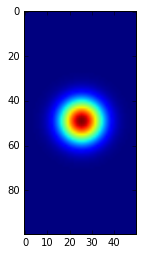

In [10]:
data = np.load("Udata.npz")
plt.imshow(np.vstack(data['U']))
print data['U'].shape

In [12]:
!pwd

/home/users/marcin.kostur/mpi_tmpdir


## non-contigous slice

In [13]:
%%writefile mpi003.py

from mpi4py import MPI
import numpy as np 

comm = MPI.COMM_WORLD
rank = comm.Get_rank()


def numpy_diff2d(u,dx2,dy2,c):

    A = (1.0-2.0*(c/dx2+c/dy2))
    u[1:-1,1:-1] =A*u[1:-1,1:-1] + c/dy2*(u[2:,1:-1] + u[:-2,1:-1]) + \
                                   c/dx2*(u[1:-1,2:] + u[1:-1,:-2])

        
N=52
Niter=211
dx = 0.1
dy = 0.1
dx2 = dx*dx
dy2 = dy*dy
dt = 0.01
D = 0.1
c = D*dt

u = np.zeros([N, N])       

if rank == 0:
    u[u.shape[1]/2,-2] = 1.0/np.sqrt(dx2*dy2)
    print "CLF = ",c/dx2,c/dy2
  
for i in range(Niter):
    
    if rank == 0:
        OUT = u[:,-2].copy()  
        IN = np.empty_like(OUT)
        comm.Send([OUT, MPI.FLOAT], dest=1)
        comm.Recv([IN, MPI.FLOAT], source=1)     
        u[:,-1] = IN
    elif rank == 1: 
        OUT = u[:,1].copy()
        IN = np.empty_like(OUT)               
        comm.Recv([IN, MPI.FLOAT], source=0)     
        comm.Send([OUT, MPI.FLOAT], dest=0)
        u[:,0] = IN
        
    numpy_diff2d(u,dx2,dy2,c)
        
np.savez("udata%04d"%rank, u=u)    


Writing mpi003.py


In [14]:
!mpirun -n 2 python mpi003.py

CLF =  0.1 0.1


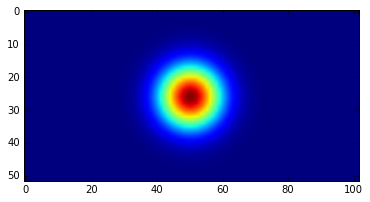

In [16]:
u1 = np.load('udata0000.npz')['u']
u2 = np.load('udata0001.npz')['u']
plt.imshow(np.hstack([u1[:,:-1],u2[:,1:]]))

## N - slices

In [17]:
%%writefile mpi004.py

from mpi4py import MPI
  
import numpy as np 

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
Nproc = comm.size

def numpy_diff2d(u,dx2,dy2,c):

    A = (1.0-2.0*(c/dx2+c/dy2))
    u[1:-1,1:-1] = A*u[1:-1,1:-1] + c/dy2*(u[2:,1:-1] + u[:-2,1:-1]) + \
                                    c/dx2*(u[1:-1,2:] + u[1:-1,:-2])

N = 16*128        
Nx = N
Ny = N/Nproc

Niter=200
dx = 0.1
dy = 0.1
dx2 = dx*dx
dy2 = dy*dy
dt = 0.01
D = 0.2
c = D*dt

u = np.zeros([Ny, Nx])       

if rank == 0:
    u[-2,u.shape[1]/2] = 1.0/np.sqrt(dx2*dy2)
    print "CLF = ",c/dx2,c/dy2

t0 = MPI.Wtime()

for i in range(Niter):
    
    if Nproc>1:
        if rank == 0:       
            comm.Send([u[-2,:], MPI.FLOAT], dest=1)
        if rank >0  and rank < Nproc-1:
            comm.Recv([u[0,:], MPI.FLOAT], source=rank-1)
            comm.Send([u[-2,:], MPI.FLOAT], dest=rank+1)    
        if rank == Nproc - 1:               
            comm.Recv([u[0,:], MPI.FLOAT], source=Nproc-2)     
            comm.Send([u[1,:], MPI.FLOAT], dest=Nproc-2)
        if rank >0  and rank < Nproc-1:
            comm.Recv([u[-1,:], MPI.FLOAT], source=rank+1)
            comm.Send([u[1,:], MPI.FLOAT], dest=rank-1)
        if rank == 0:
            comm.Recv([u[-1,:], MPI.FLOAT], source=1)   
    
    #print rank
    
    comm.Barrier()
    numpy_diff2d(u,dx2,dy2,c)

t1 = MPI.Wtime()    
print rank,t1-t0
    
#np.savez("udata%04d"%rank, u=u)    
if Nproc>1:
    U = comm.gather(u[1:-1,1:-1])

    if rank==0:
         np.savez("Udata", U=U)    
    

Writing mpi004.py


In [18]:
!mpirun -H gpu2,gpu3 python mpi004.py

/usr/bin/ssh: /opt/puppetlabs/puppet/lib/libcrypto.so.1.0.0: no version information available (required by /usr/bin/ssh)
/usr/bin/ssh: /opt/puppetlabs/puppet/lib/libcrypto.so.1.0.0: no version information available (required by /usr/bin/ssh)
CLF =  0.2 0.2
0 6.95832514763
1 6.93596291542


In [19]:
!mpirun -n 4 python mpi004.py

CLF =  0.2 0.2
0 4.19562888145
1 4.18583106995
2 4.19542193413
3 4.22370481491


(4, 510, 2046)


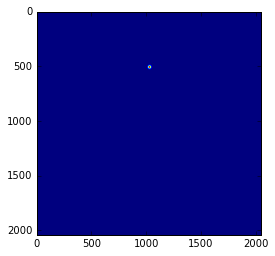

In [21]:
data = np.load("Udata.npz")
plt.imshow(np.vstack(data['U']))
print data['U'].shape

In [22]:
a = np.arange(0,16).reshape(4,4)

In [23]:
b = a[:,2]
c = a[2,:]

In [24]:
np.may_share_memory(a,b),np.may_share_memory(a,c)

(True, True)

In [25]:
a.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [26]:
b.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [27]:
c.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [28]:
a=np.array(range(6))

In [29]:
b = a[2:4]

In [30]:
b=666


In [32]:
print a

[0 1 2 3 4 5]


In [60]:
np.may_share_memory?
